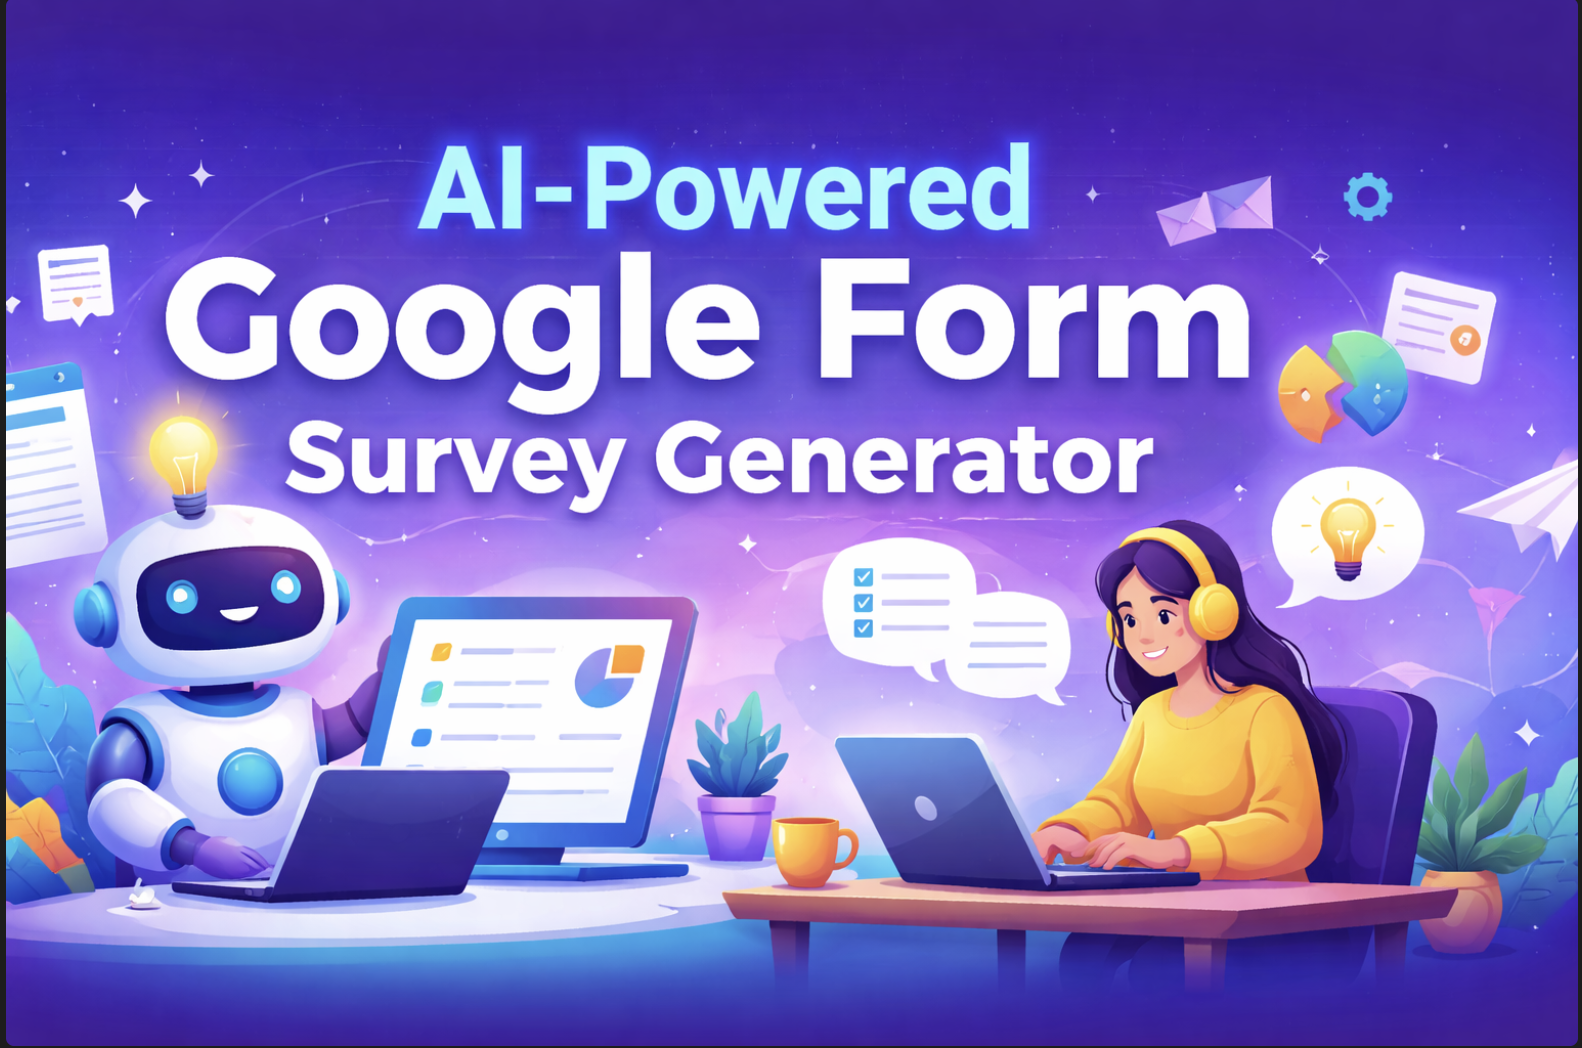


## 📦 Install Libraries

In [28]:
# !pip3 install -qU langchain langchain-google-genai langchain-core python-dotenv requests


## 🔐 Load ENV

In [36]:
import os
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv("APIKEY")
MODEL = os.getenv("MODEL")


## 🤖 Setup LangChain Brain

In [37]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model=MODEL,
    google_api_key=API_KEY,
    temperature=0.3
)


## 🔧 Define Tools (Google Form Creator)

In [38]:
import requests
import json
from langchain_core.tools import tool


APPS_SCRIPT_URL = "https://script.google.com/macros/s/AKfycbzm1DuZxcuQyhyLLzgTgak61c7qMHT7HEbj0sfva_j3oGjkeiquqBh4l_E-Jma1lP_X/exec"

CONFIG_CACHE = {}
TYPE_MAP = {
    "shortanswer": "short",
    "short_answer": "short",
    "short": "short",

    "paragraph": "paragraph",
    "long": "paragraph",

    "multiplechoice": "mcq",
    "multiple_choice": "mcq",
    "mcq": "mcq",

    "checkbox": "checkbox",
    "check": "checkbox",

    "dropdown": "dropdown",
    "select": "dropdown",

    "file": "file",
    "upload": "file",

    "linear": "linear",
    "scale": "linear",

    "rating": "rating",

    "mcq_grid": "mcq_grid",
    "checkbox_grid": "checkbox_grid",

    "date": "date",
    "time": "time"
}

def normalize_config(config):
    for q in config["questions"]:
        t = q.get("type", "").lower().replace(" ", "").replace("-", "_")

        if t in TYPE_MAP:
            q["type"] = TYPE_MAP[t]
        else:
            q["type"] = "short"   # fallback safe

    return config


def create_google_form(config: dict):
    response = requests.post(
        APPS_SCRIPT_URL,
        headers={"Content-Type": "application/json"},
        data=json.dumps(config),
        timeout=30
    )
    return response.json()


@tool
def generate_survey_config(user_input: str) -> dict:
    """Generate survey JSON config based on user description."""
    
    prompt = f"""
Create Google Form JSON config.
User Requirement:
{user_input}

Rules:
- Title short
- Description 3-4 lines
- Questions based on user count
- Return ONLY valid JSON

Format:
{{
 "title":"",
 "description":"",
 "linkSheet": true,
 "questions":[]
}}
"""
    response = llm.invoke(prompt).content
    clean_resp = response.strip().replace("```json", "").replace("```", "")
    global CONFIG_CACHE
    CONFIG_CACHE = json.loads(clean_resp)
    return CONFIG_CACHE

    

@tool
def call_create_google_form_tool() -> dict:
    """Creates Google Form using JSON config."""
    global CONFIG_CACHE
    if CONFIG_CACHE is None:
        return {"error": "Survey config missing"}
    else:
        CONFIG_CACHE = normalize_config(CONFIG_CACHE)
    return create_google_form(CONFIG_CACHE)



## 📝 Prompt Template

In [39]:
# from langchain_core.prompts import ChatPromptTemplate

# prompt_template = ChatPromptTemplate.from_messages([
#     ("system", """
# You are a survey generator AI.
# Always return ONLY valid JSON.
# Always call generate_survey_config before create_google_form_tool.
# No explanations.
# """),

#     ("human", """
# User Intent:
# {user_input}

# Generate JSON ONLY in this format:

# {{
#  "title": "",
#  "description": "",
#  "linkSheet": true,
#  "questions": [
#    {{"type":"short","title":"","required":true}},
#    {{"type":"mcq","title":"","options":[""],"required":true}}
#  ]
# }}

# Rules:
# - Title short
# - Description 3–4 lines
# - Respect number of questions user wants
# - Tone based on user input
# - Only valid JSON output
# """)
# ])


## 🎯 Agent Creation

In [40]:
from langchain_classic.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate

def create_survey_agent():

    tools = [generate_survey_config, call_create_google_form_tool]

    llm_with_tools = llm.bind_tools(tools)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """
You are a Survey Automation AI Agent.

Workflow:
1. First call generate_survey_config
2. Then call call_create_google_form_tool
3. Always call generate_survey_config before create_google_form_tool.
4. Never answer without tools
5. Return final Google Form links
"""),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}")
    ])

    agent = create_tool_calling_agent(
        llm_with_tools,
        tools,
        prompt
    )

    return AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=True
    )


## 💬 Collect User Intent

In [41]:
survey_topic = input("What is the survey about? ")
tone = input("Tone? (fun/formal/professional) ")
num_qs = input("How many questions? ")

user_input = f"""
Survey Topic: {survey_topic}
Tone: {tone}
Number of Questions: {num_qs}
"""


What is the survey about?  Research Survey on High school students as in how much they are leveraging AI for Studies
Tone? (fun/formal/professional)  fun
How many questions?  5


## 🟢🤖 Run Agent

In [42]:
survey_agent = create_survey_agent()

result = survey_agent.invoke({
    "input": f"Create a Survey: {user_input}"

})

print(result)




> Entering new AgentExecutor chain...

Invoking: `generate_survey_config` with `{'user_input': 'Survey Topic: Research Survey on High school students as in how much they are leveraging AI for Studies, Tone: fun, Number of Questions: 5'}`


{'title': 'AI Study Buddy Check-in!', 'description': "Hey high schoolers! Ever wonder if your classmates are secretly AI wizards? We're on a quest to uncover how much you're tapping into AI tools for homework, projects, and maybe even dodging chores (just kidding... mostly!). Spill the beans on your AI adventures and help us understand the future of learning. It's quick, fun, and totally anonymous!", 'linkSheet': True, 'questions': [{'type': 'RADIO', 'title': 'How often do you summon your AI study buddy for schoolwork?', 'options': ["Never (I'm old school!)", "Rarely (only when I'm super stuck)", "Sometimes (it's a handy helper)", "Often (it's my go-to for many tasks)", 'All the time (my AI does my homework... just kidding!)']}, {'type': 'TEXT', 't